In [135]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# supernovae_lst = pd.read_csv("./TESS_data/sn_count_transients_s1-47 (4).txt")
transients = pd.read_csv("./TESS_data/AT_count_transients_s1-47 (4).txt", names=["sector", "ra", "dec", "mag", "TJD", "type" ,"class", "IAU", "survey", "cam", "ccd", "col", "row"], delim_whitespace=True)
display(transients)

,sector,ra,dec,mag,TJD,type,class,IAU,survey,cam,ccd,col,row
0,1,327.160083,-43.380019,17.800,1340.340,SN,SNIa,2018evo,ASAS-SN,1,1,1860.105,322.643
1,1,315.033417,-40.358594,17.869,1341.926,SN,SNIa,2018exc,ATLAS,1,1,528.652,1304.728
2,1,313.474583,-38.015594,18.781,1347.901,SN,SNII,2018fgb,ATLAS,1,1,424.192,1751.547
3,1,332.648000,-27.250161,16.700,1331.630,SN,SNII,2018emt,ASAS-SN,1,3,642.568,1607.839
4,1,327.584333,-26.300131,19.405,1337.965,AT,Unclassified,2018esp,ATLAS,1,3,1303.439,1157.924
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398,47,167.461817,75.334383,20.670,2601.001,AT,Unclassified,2022aji,Pan-STARRS1,3,2,521.417,1084.865
4399,47,210.216792,78.085778,19.680,2601.143,AT,Unclassified,2022aha,Pan-STARRS1,3,3,1679.425,1415.721
4400,47,300.459933,85.849581,18.075,2588.733,AT,Unclassified,2022gn,ATLAS,3,4,1667.608,986.600
4401,47,256.141083,76.155150,18.470,2589.662,AT,Unclassified,2022op,GaiaAlerts,4,1,1990.840,279.007


In [142]:
light_curves = os.listdir("./TESS_data/light_curves_fausnaugh")
# name = light_curves[random.randint(0, len(light_curves)-1)]
# print(light_curves[i])
filename = "lc_2021xgw_cleaned"
curve = pd.read_csv("./TESS_data/light_curves_fausnaugh/" + filename, delim_whitespace=True)

display(curve)

,BTJD,TJD,cts,e_cts,bkg,bkg_model,bkg2,e_bkg2
0,2447.69674,2447.68761,-1172.5524,715.2312,-250.8033,7.7552,-995.8400,715.2312
1,2447.70369,2447.69456,-189.8238,709.4724,3.7264,83.1414,304.4987,709.4724
2,2447.71063,2447.70150,-666.6020,710.6165,-180.2586,83.1414,-294.4149,710.6165
3,2447.71758,2447.70845,-542.2016,711.1438,96.4165,83.1414,103.1520,711.1438
4,2447.72452,2447.71539,347.6588,722.0036,-74.6394,83.1414,83.1414,722.0036
...,...,...,...,...,...,...,...,...
2875,2471.27310,2471.26399,2174.5468,1151.9727,-6986.1671,367.1052,1636.8312,1151.9727
2876,2471.28005,2471.27094,359.8219,1177.5992,-6131.0641,471.2100,-234.8776,1177.5992
2877,2471.28699,2471.27788,2971.5368,1257.8571,-1596.6593,367.1052,1191.3554,1257.8571
2878,2471.29394,2471.28483,1916.8104,1284.0115,-2757.0628,367.1052,1351.1282,1284.0115


In [141]:
curve_name = filename.split("_")[1]
curve_meta = transients[transients['IAU'] == curve_name]

def display_curve(col):
    curve.plot.scatter(x="BTJD", y=col, c="00000", alpha=0.5, yerr=curve["e_cts"], ylabel="Flux", xlabel="Barycentric TESS Julian Date", title=curve_name)

display(curve_meta)

,sector,ra,dec,mag,TJD,type,class,IAU,survey,cam,ccd,col,row
3567,42,340.437763,-4.713439,20.39,2456.881,AT,Unclassified,2021xgw,Pan-STARRS1,1,2,453.477,1799.166


# Preprocessing steps
## 1. Sigma Clipping: remove points with flux uncertainties more than 3 sigma from mean uncertainty, repeat clipping 5 times

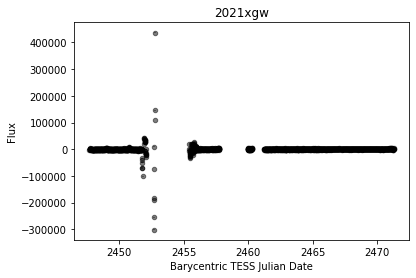

In [138]:
for _ in range(0, 5):
    uncert_mean = curve.e_cts.mean()
    threshold = 3*curve.e_cts.std()
    curve = curve[np.abs(curve['e_cts'] - uncert_mean) <= threshold]

display_curve("cts")

## 2. Subtract background Flux

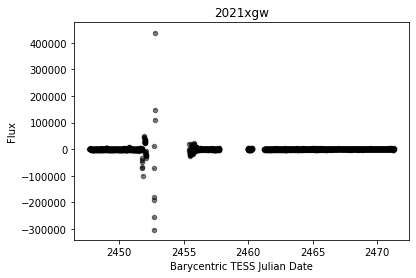

In [139]:
curve['no_bkg_cts'] = curve['cts'] - curve['bkg_model']
display_curve('no_bkg_cts')

## 3. Correct for milky way extinction using Fitzpatrick Reddening function
Wavelength of TESS bandpass is between 600-1000nm, central wavelength is 786.5nm

In [140]:
import extinction
from astroquery.irsa_dust import IrsaDust
import astropy.coordinates as coord
import astropy.units as u

# Set relevant parameters
ra = curve_meta["ra"]
dec = curve_meta["dec"]
flux_in = curve["cts"]
fluxerr_in = curve["e_cts"]
bandpass_wavelengths = np.array([786.5,])


# Get Milky Way E(B-V) Extinction
coo = coord.SkyCoord(ra * u.deg, dec * u.deg, frame='icrs')
dust = IrsaDust.get_query_table(coo, section='ebv')
mwebv = dust['ext SandF mean'][0]


# Remove extinction from light curves (Using negative a_v so that extinction.apply works in reverse and removes the extinction)
extinction_per_passband = extinction.fitzpatrick99(wave=bandpass_wavelengths, a_v=-3.1 * mwebv, r_v=3.1, unit='aa')
flux_out = extinction.apply(extinction_per_passband[0], flux_in, inplace=False)
fluxerr_out = extinction.apply(extinction_per_passband[0], fluxerr_in, inplace=False)

Exception: The dust service responded with an error: 
    Coordinate [[340.4377685] [-4.71343466]] lookup error: Invalid object name.
  

## 4. Normalize Data

In [ ]:
curve['normalized_cts'] = (curve.no_bkg_cts - curve.no_bkg_cts.min()) / (curve.no_bkg_cts.max()-curve.no_bkg_cts.min())
curve.plot.scatter(x="BTJD", y='normalized_cts', c="00000", alpha=0.5, ylabel="Flux", xlabel="Barycentric TESS Julian Date")

## 5. Bin data (May be needed)

# Find training labels
## 1. Max Light

In [ ]:
t_max = curve["normalized_cts"].idxmax()
display(t_max)

## 2. Explosion Time